# Algebraic and AI-Assisted Anomaly Detection for Robotic Sensor Data

## PCA, Kernel PCA and Autoencoder

- Load normalized data
- PCA recon error (Q-residual) + Hotelling's T2
- Kernel PCA recon error
- Autoencoder recon error
- Compare and save scores/configs for later

[INFO] tensorflow imported
[INFO] Normalized datasets found:
 - lp1_norm.csv
 - lp2_norm.csv
 - lp3_norm.csv
 - lp4_norm.csv
 - lp5_norm.csv
[INFO] Datasets loaded: ['lp1', 'lp2', 'lp3', 'lp4', 'lp5']

=== Dataset: lp1 ===
[INFO] Using numeric matrix X: 1320 samples x 6 features
[INFO] PCA recon scores obtained
[INFO] kpca_rec calculated correctly
[INFO] KPCA recon scores obtained
[INFO] Autoencoder compiled correctly!
[INFO] Autoencoder recon scores obtained
[INFO] Saved scores -> ../results/lp1_pca_kpca_ae.csv
[INFO] Saved meta → ../results/lp1_pka_meta.json

=== Dataset: lp2 ===
[INFO] Using numeric matrix X: 705 samples x 6 features
[INFO] PCA recon scores obtained
[INFO] kpca_rec calculated correctly
[INFO] KPCA recon scores obtained
[INFO] Autoencoder compiled correctly!
[INFO] Autoencoder recon scores obtained
[INFO] Saved scores -> ../results/lp2_pca_kpca_ae.csv
[INFO] Saved meta → ../results/lp2_pka_meta.json

=== Dataset: lp3 ===
[INFO] Using numeric matrix X: 705 samples x 6

,PCA_Q_mean,KPCA_mean,AE_mean
Dataset,,,
lp1,2.980742e-02,0.664956,0.011940
lp2,2.037437e-02,0.818144,0.063450
lp3,2.037437e-02,0.818144,0.114309
lp4,4.220893e-31,0.875588,0.092009
lp5,3.838563e-31,0.861119,0.043794


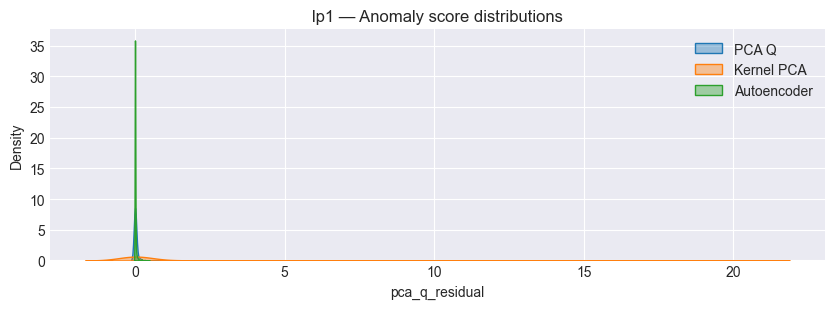

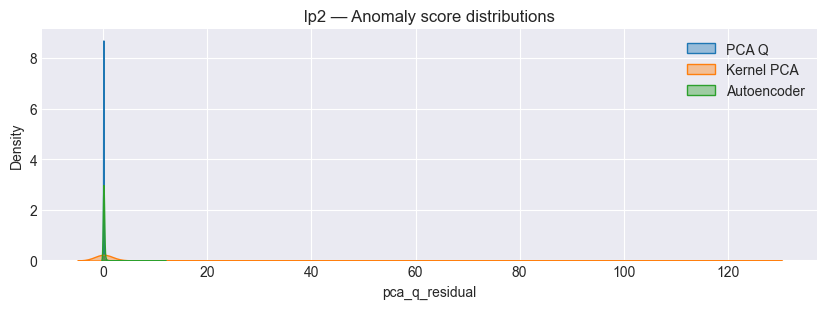

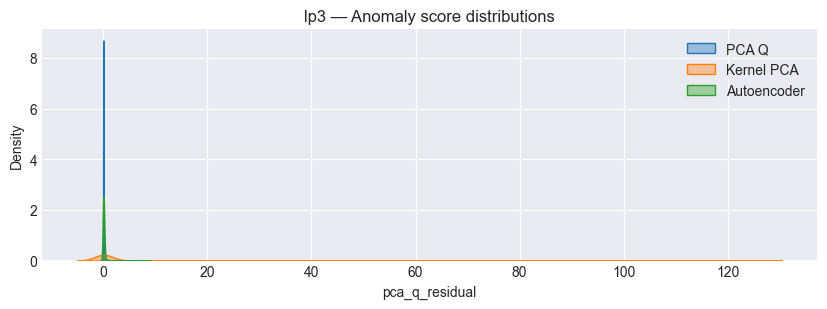

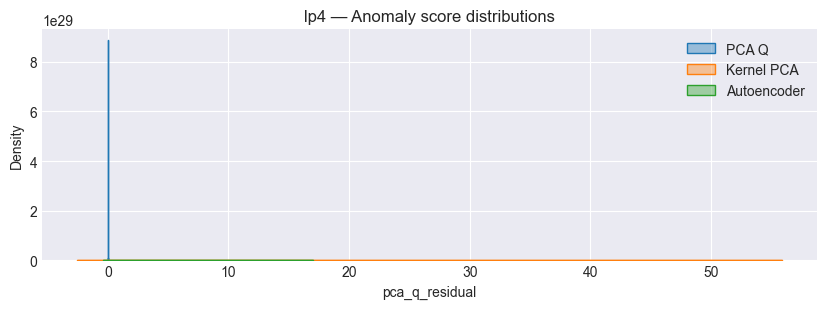

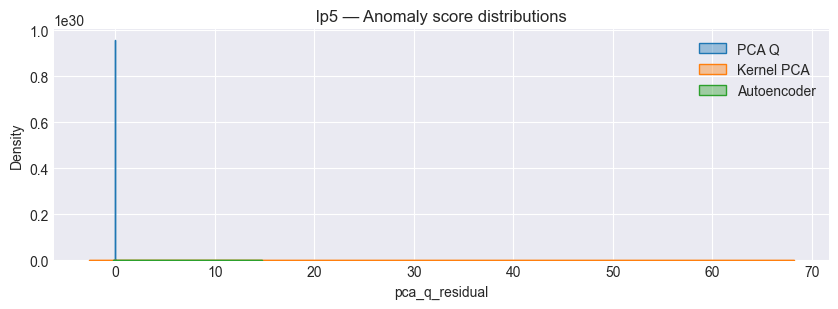


[INFO] Method mean-score correlations across datasets


,PCA_Q,KPCA,AE
PCA_Q,1.000,-0.848,-0.286
KPCA,-0.848,1.000,0.653
AE,-0.286,0.653,1.000


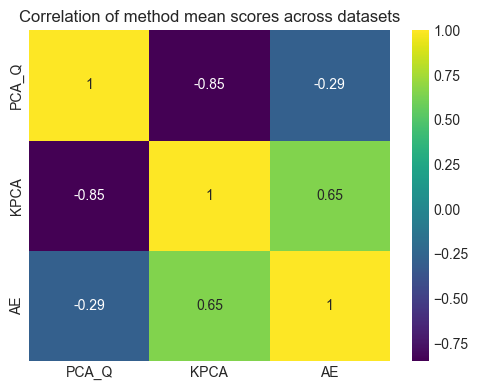

In [7]:
# --- 1. Imports ---
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.spatial.distance import pdist
from scipy.stats import chi2

# Keras (Autoencoder)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    HAS_TF = True
    print(f"[INFO] tensorflow imported")
except Exception:
    HAS_TF = False

SEED = 42
np.random.seed(SEED)
if HAS_TF:
    tf.random.set_seed(SEED)

plt.style.use("seaborn-v0_8-darkgrid")
pd.set_option("display.max_columns", None)


# --- 2. Paths ---
data_path = Path("../data/normalized")
files = sorted(data_path.glob("*.csv"))
results_path = Path("../results")
results_path.mkdir(exist_ok=True)

print("[INFO] Normalized datasets found:")
for f in files:
    print(f" - {f.name}")

# --- 3. Load datasets ---
datasets = {f.stem.replace("_norm", ""): pd.read_csv(f) for f in files}
print(f"[INFO] Datasets loaded: {list(datasets.keys())}")


"""Helper methods"""

def choose_pca_components(X, var_ratio=0.95):
    # return n_components that achieve explained_variance >= var_ratio
    pca = PCA(n_components=min(X.shape[0], X.shape[1])).fit(X)
    csum = np.cumsum(pca.explained_variance_ratio_)
    n = int(np.searchsorted(csum, var_ratio)+1)
    return max(1, min(n, X.shape[1]))

def pca_recon_scores(X, n_components=None, var_ratio=0.95):
    if n_components is None:
        n_components = choose_pca_components(X, var_ratio=var_ratio)
    
    pca = PCA(n_components=n_components, random_state=SEED)
    Z = pca.fit_transform(X)
    X_hat = pca.inverse_transform(Z)

    q_residual = np.mean((X - X_hat)**2, axis=1)

    eigvals = pca.explained_variance_
    eigvals_inv = np.where(eigvals > 1e-12, 1.0/eigvals, 0.0)
    T2 = np.sum((Z**2) * eigvals_inv, axis=1)
    return q_residual, T2, pca

def median_pairwise_sigma(X, max_samples=2000):
    if X.shape[0] > max_samples:
        idx = np.random.RandomState(SEED).choice(X.shape[0], max_samples, replace=False)
        Xs = X[idx]
    else:
        Xs = X
    
    dists = pdist(Xs, metric="euclidean")
    median = np.median(dists)
    return median if median>0 else 1.0

def kpca_recon_scores(X, n_components=None, gamma=None, var_ratio=0.95):
    if n_components is None:
        n_components = choose_pca_components(X, var_ratio=var_ratio)
        n_components = max(2, min(n_components, min(50, X.shape[1])))

    if gamma is None:
        # sigma heuristic -> gamma = 1/(2*sigma^2)
        sigma = median_pairwise_sigma(X)
        gamma = 1.0 / (2.0 * (sigma**2))
    
    kpca = KernelPCA(
        n_components=n_components,
        kernel="rbf",
        gamma=gamma,
        fit_inverse_transform=True,
        n_jobs=-1,
        random_state=SEED
    )
    Z = kpca.fit_transform(X)
    try:
        X_hat = kpca.inverse_transform(Z)
        kpca_rec = np.mean((X - X_hat)**2, axis=1)
        print(f"[INFO] kpca_rec calculated correctly")
    except Exception:
        # Fallback: use squared norm in feature space (proxy)
        # score = ||ϕ(x)||^2 - sum_{i=1..m} <ϕ(x), u_i>^2 = k(x,x) - ||projection||^2
        # sklearn does not expose this directly; approximate with latent energy
        kpca_rec = np.sum(Z**2, axis=1)  # monotonic proxy
        print(f"[WARNING] Fallback for kpca_rec")
    return kpca_rec, kpca

def build_autoencoder(input_dim, bottleneck=None, dropout=0.0):
    if bottleneck is None:
        bottleneck = max(2, min(16, input_dim // 2))
    
    input = keras.Input(shape=(input_dim,))
    x = layers.Dense(max(64, input_dim*2), activation="relu")(input)
    if dropout>0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(max(32, input_dim), activation="relu")(x)
    z = layers.Dense(bottleneck, activation="linear", name="bottleneck")(x)
    x = layers.Dense(max(32, input_dim), activation="relu")(z)
    x = layers.Dense(max(64, input_dim*2), activation="relu")(x)
    output = layers.Dense(input_dim, activation="linear")(x)
    ae = keras.Model(input, output)
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    print(f"[INFO] Autoencoder compiled correctly!")
    return ae



"""Main Testing Loop"""

ALL_RESULTS = []
scores_store = {}

# columns that might represent labels if present
LABEL_CANDIDATES = {"label", "class", "target", "y", "failure", "anomaly"}

for name, df in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    num_df = df.select_dtypes(include=np.number).dropna()
    X = num_df.values
    n, d = X.shape
    print(f"[INFO] Using numeric matrix X: {n} samples x {d} features")

    # Try to find a label if present
    label_col = None
    for c in df.columns:
        if c.lower() in LABEL_CANDIDATES:
            label_col = c
            break
    y = None
    if label_col is not None:
        y = df.loc[num_df.index, label_col]
        # Convert to binary if not already (heuristic)
        if y.nunique() > 2:
            y = (y != y.mode().iloc[0]).astype(int)
        else:
            y = y.astype(int)
        print(f"[INFO] Found label column: {label_col}")

    # -- PCA --
    pca_q, pca_t2, pca_model = pca_recon_scores(X, var_ratio=0.95)
    print(f"[INFO] PCA recon scores obtained")

    # -- Kernel PCA --
    kpca_rec, kpca_model = kpca_recon_scores(X, var_ratio=0.95)
    print(f"[INFO] KPCA recon scores obtained")

    # -- Autoencoder --
    if HAS_TF:
        X_train, X_val = train_test_split(X, test_size=0.2, random_state=SEED, shuffle=True)
        autoencoder = build_autoencoder(d, bottleneck=max(2, min(16, d//2)), dropout=0.0)
        callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        ]
        hist = autoencoder.fit(
            X_train, X_train,
            validation_data=(X_val, X_val),
            epochs=200,
            batch_size=min(256, max(32, n//20)),
            verbose=0,
            callbacks=callbacks
        )
        X_hat = autoencoder.predict(X, verbose=0)
        ae_rec = np.mean((X - X_hat)**2, axis=1)
        print(f"[INFO] Autoencoder recon scores obtained")
    else:
        print("[WARNING] TensorFlow not found: skipping Autoencoder (install tensorflow to enable).")
        ae_rec = np.full(shape=(n,), fill_value=np.nan)
    
    # Collect scores
    scores_df = pd.DataFrame({
        "pca_q_residual": pca_q,
        "pca_hotelling_t2": pca_t2,
        "kpca_recon": kpca_rec,
        "ae_recon": ae_rec
    })

    # Supervised metrics if y available (plus)
    metrics = {}
    if y is not None:
        for col in ["pca_q_residual", "kpca_recon", "ae_recon"]:
            if scores_df[col].isna().all():
                continue
            try:
                metrics[f"{col}_roc_auc"] = roc_auc_score(y, scores_df[col])
                metrics[f"{col}_avg_precision"] = average_precision_score(y, scores_df[col])
            except Exception:
                pass
    
    # save results per dataset
    out_csv = results_path / f"{name}_pca_kpca_ae.csv"
    scores_df.to_csv(out_csv, index=False)
    print(f"[INFO] Saved scores -> {out_csv}")

    # Save config/model metadata
    meta = {
        "dataset": name,
        "n_samples": int(n),
        "n_features": int(d),
        "pca_n_components": int(pca_model.n_components_),
        "kpca_n_components": int(kpca_model.n_components),
        "kpca_gamma": float(kpca_model.gamma),
        "has_autoencoder": bool(HAS_TF),
        "metrics_if_labels": metrics
    }
    with open(results_path / f"{name}_pka_meta.json", "w") as f:
        json.dump(meta, f, indent=2)
    print(f"[INFO] Saved meta → {results_path / f'{name}_pka_meta.json'}")

    # Store for cross-dataset summary
    scores_store[name] = scores_df
    row = {
        "Dataset": name,
        "PCA_Q_mean": float(np.nanmean(scores_df["pca_q_residual"])),
        "KPCA_mean": float(np.nanmean(scores_df["kpca_recon"])),
        "AE_mean": float(np.nanmean(scores_df["ae_recon"])),
    }
    row.update({k: float(v) for k, v in metrics.items()})
    ALL_RESULTS.append(row)



"""Comparison and Plots"""
summary_df = pd.DataFrame(ALL_RESULTS).set_index("Dataset")
display(summary_df)

# Distributions per dataset
for name, sdf in scores_store.items():
    plt.figure(figsize=(10,3))
    sns.kdeplot(sdf["pca_q_residual"], label="PCA Q", fill=True, alpha=0.4)
    sns.kdeplot(sdf["kpca_recon"], label="Kernel PCA", fill=True, alpha=0.4)
    if not sdf["ae_recon"].isna().all():
        sns.kdeplot(sdf["ae_recon"], label="Autoencoder", fill=True, alpha=0.4)
    plt.title(f"{name} — Anomaly score distributions")
    plt.legend()
    plt.show()

# Cross-dataset correlation of scores (mean method-level signal)
method_means = []
for name, sdf in scores_store.items():
    method_means.append({
        "Dataset": name,
        "PCA_Q": np.nanmean(sdf["pca_q_residual"]),
        "KPCA": np.nanmean(sdf["kpca_recon"]),
        "AE": np.nanmean(sdf["ae_recon"]),
    })

method_means_df = pd.DataFrame(method_means).set_index("Dataset")
corr_methods = method_means_df.corr()
print("\n[INFO] Method mean-score correlations across datasets")
display(corr_methods.round(3))

plt.figure(figsize=(5,4))
sns.heatmap(corr_methods, annot=True, cmap="viridis")
plt.title("Correlation of method mean scores across datasets")
plt.tight_layout()
plt.show()